##### Author contributions
Please fill out for each of the following parts who contributed to what:
- Conceived ideas: 
- Performed math exercises: 
- Performed programming exercises:
- Contributed to the overall final assignment: 

# Chapter 6
## Deep learning


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Brightspace before the deadline (see Brightspace).

Learning goals:
1. Get familiar with a state-of-the-art module for deep learning
1. Implement and run a multilayer neural network in PyTorch
1. Understand convolution
1. Implement and run a convolutional neural network in PyTorch

In [1]:
import matplotlib.pyplot as plt
from scipy import signal as ss
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

It might occur that the above imports throw an error, saying `torch` is an unknown module. If so, you have not yet installed `pytorch` properly. Do so by opening a terminal and installing it by calling `conda install pytorch torchvision -c pytorch` (i.e., see https://pytorch.org/get-started/locally/).

When working on a state-of-the-art neural network project you will rely on one of the various neural network frameworks that are available, instead of implementing core functionality by yourself. In this exercise you will work on implementing an MLP and a CNN in the PyTorch framework. 

To get familiar with PyTorch, read the tutorial at https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html. It is a good introduction to PyTorch including setting up data, defining a model, and training a model. 

### Exercise 1: MNIST data (1 point)
We will use the MNIST dataset (handwritten digets) for this assignment. The dataset is a very standard and commonly used benchmark dataset. In this assignment, we will only work with a training and validation dataset. Normally, one would also have a testing dataset, but we will ignore this in this assignment.
1. Load the *MNIST* dataset. Use a training and a validation dataset.
1. Define training and validation data iterators and use a specific batchsize.
1. Inspect the training and validation data by printing (1) the amount of samples in each set and (2) the shape of a data sample.
1. Inspect the training and validation data by plotting some samples (as images).

### Solution 1

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100

In [3]:
print(str(device) + " :(")

cpu :(


The size of the training data is: 60000. And the size of the testing data is: 10000 
The size/shape of a single example is: torch.Size([1, 28, 28]).


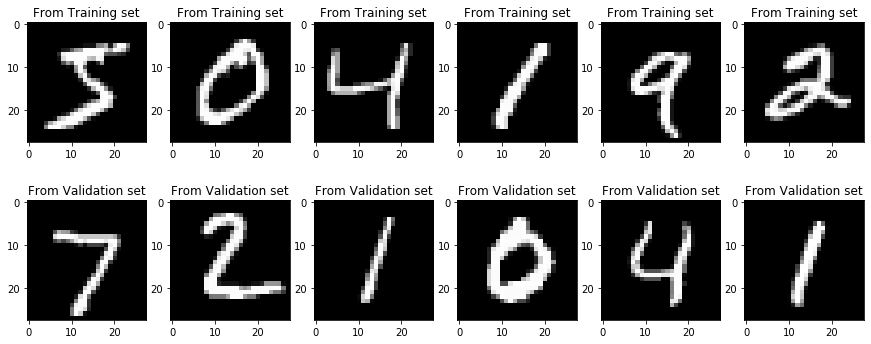

In [4]:
train_data = torchvision.datasets.MNIST(root="~/Documents/nncourse",
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True
                                  )

valid_data = torchvision.datasets.MNIST(root="~/Documents/nncourse",
                                   train=False,
                                   transform=transforms.ToTensor()
                                 )

train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True) 

valid_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False)

print("The size of the training data is: {}. And the size of the testing data is: {} ".format(len(train_data),len(valid_data)))
print("The size/shape of a single example is: {}.".format(train_data[0][0].size()))



fig, ax = plt.subplots(2,6,figsize=(15,6))
for i in range(ax.shape[1]):
    ax[0][i].imshow(train_data[i][0][0],cmap='gray')
    ax[0][i].set_title("From Training set")
    ax[1][i].imshow(valid_data[i][0][0],cmap='gray')
    ax[1][i].set_title("From Validation set")
plt.show()

In [5]:
train = iter(train_data)
sample, labels = next(train)
print(sample.size())

torch.Size([1, 28, 28])


### Exercise 2: Training a model (3 points)
Define a function `train_model` with input arguments `model`, `train_data`, `valid_data`, `optimizer`, `criterion`, and `n_epochs`, and output arguments `model`, `train_loss`, `valid_loss`, `train_accuracy`, `valid_accuracy`. We will use this function to train both a MLP as well as a CNN. It therefore has to be generic to any type of model, optimizer, or loss function. The function:
1. Loops over `n_epoch` epochs.
1. Loops over minibatches of both training data `train_data` as well as validation data `valid_data`.
1. Trains the model using the loss function defined by `criterion` and optimizer `optimizer` using the training data.
1. Computes and saves losses for both training and validation data per epoch in `train_loss` and `valid_loss`.
1. Computes and saves accuracies for both training and validation data per epoch in `train_accuracy` and `valid_accuracy`.

### Solution 2

In [6]:
def train_model(model,train_data,valid_data,optimizer,criterion,n_epochs):
    start = time.time()
    train_loss = np.zeros(n_epochs)
    valid_loss = np.zeros(n_epochs)
    train_accuracy = np.zeros(n_epochs) 
    valid_accuracy = np.zeros(n_epochs)
    
    for epoch in range(n_epochs): 
        train_losses = []
        valid_losses = []
        correct_train = 0
        total_train   = 0

        for i,(images,labels) in enumerate(train_data):
            optimizer.zero_grad()

            #images = images.reshape(-1,28*28).to(device)
            images = images.to(device)
            labels = labels.to(device)
            
            #Forward pass
            outputs = model.forward(images)
            loss    = criterion(outputs, labels)
            
            #Backward pass
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            _, predicted = torch.max(outputs.data,1)
            correct_train += (predicted == labels).sum().item()
            total_train   += labels.size(0)
            
        train_loss[epoch] = np.mean(train_losses)
        train_accuracy[epoch] = (100 * correct_train/total_train)
        with torch.no_grad():
            correct = 0
            total   = 0
            for images,labels in valid_data:
            
                images = images.reshape(-1,28*28).to(device)
                labels = labels.to(device)
            
                outputs = model(images)
                loss    = criterion(outputs,labels)
                
                valid_losses.append(loss.item())
            
                _, predicted = torch.max(outputs.data, 1)
            
                correct += (predicted == labels).sum().item()
                total   += labels.size(0)
                
            valid_loss[epoch] = np.mean(valid_losses)
            valid_accuracy[epoch] = (100 * correct/total)
            
        
        print('epoch : [{},{}], train loss : {:.4f}, train accuracy : {:.2f}%, valid loss : {:.4f}, valid acc : {:.2f}%,'.
              format(epoch+1,n_epochs,train_loss[epoch],train_accuracy[epoch],valid_loss[epoch],valid_accuracy[epoch]))
    end = time.time()
    print(end - start)
    return model,train_loss,valid_loss,train_accuracy,valid_accuracy

### Exercise 3: Setup an MLP (1 point)
As a first model, setup a multilayer perceptron:
1. with two linear (i.e., fully connected) weight layers
1. with a hidden layer of 16 ReLU units

### Solution 3

In [7]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet,self).__init__()
        self.fc1  = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.fc2  = nn.Linear(hidden_size,num_classes)
        
    def forward(self,x):
        out = self.fc1(x.reshape(-1,28*28))
        out = self.relu(out)
        out = self.fc2(out)
        return out

### Exercise 4: Train the MLP (1 point) 
Train the MLP using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the MLP in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 4

In [8]:
model = NeuralNet(784,16,10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [9]:
print(model)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


In [10]:
modell,train_loss,valid_loss,train_accuracy,valid_accuracy = train_model(model,
                                                                        train_loader,
                                                                        valid_loader,
                                                                        optimizer,
                                                                        criterion,
                                                                        n_epochs=20)

epoch : [1,20], train loss : 1.7407, train accuracy : 55.28%, valid loss : 1.0262, valid acc : 78.05%,
epoch : [2,20], train loss : 0.7676, train accuracy : 82.37%, valid loss : 0.5710, valid acc : 86.01%,
epoch : [3,20], train loss : 0.5216, train accuracy : 86.91%, valid loss : 0.4438, valid acc : 88.60%,
epoch : [4,20], train loss : 0.4351, train accuracy : 88.54%, valid loss : 0.3884, valid acc : 89.63%,
epoch : [5,20], train loss : 0.3928, train accuracy : 89.28%, valid loss : 0.3584, valid acc : 90.19%,
epoch : [6,20], train loss : 0.3677, train accuracy : 89.81%, valid loss : 0.3392, valid acc : 90.64%,
epoch : [7,20], train loss : 0.3508, train accuracy : 90.23%, valid loss : 0.3266, valid acc : 90.94%,
epoch : [8,20], train loss : 0.3382, train accuracy : 90.49%, valid loss : 0.3166, valid acc : 91.26%,
epoch : [9,20], train loss : 0.3284, train accuracy : 90.72%, valid loss : 0.3088, valid acc : 91.40%,
epoch : [10,20], train loss : 0.3205, train accuracy : 90.95%, valid loss

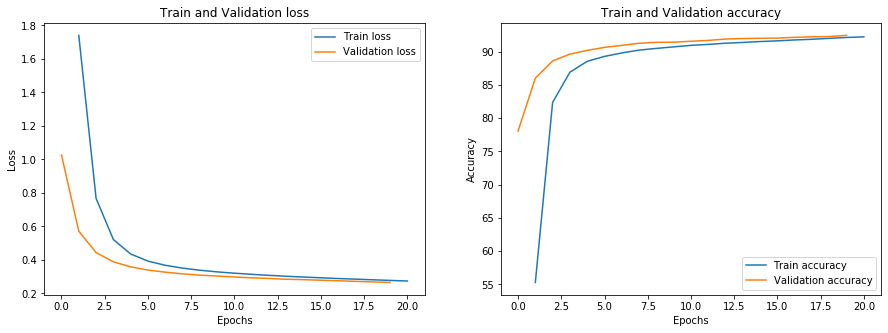

In [11]:
epoch_plot = np.arange(1,21)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(epoch_plot,train_loss,valid_loss)
ax1.set_title("Train and Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(["Train loss","Validation loss"])

ax2.plot(epoch_plot,train_accuracy,valid_accuracy)
ax2.set_title("Train and Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(["Train accuracy","Validation accuracy"])

plt.show()

### Exercise 5: Visualize the weights (0.5 points)
The model's weights in a particular layer that the MLP has learned can be found in `model_name.layer_name.weight.data`. Plot the weights of the 16 ReLU units as 2D images.

### Solution 5

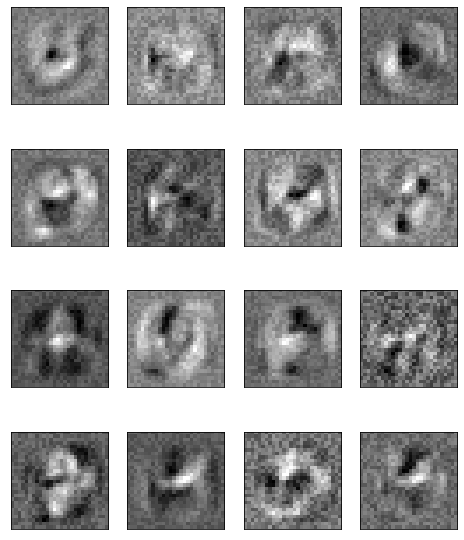

In [12]:
## Code here ##

w = modell.fc1.weight.data
plt.figure(figsize=([8,10]))
for i in range(len(w)):    
    plt.subplot(4,4,i+1)
    fig = plt.imshow(w[i, :].reshape([28,28]).T,cmap="gray")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

### Exercise 6: Convolution with hand-made kernels (1 point)
In convolutional neural networks we use a mathematical operator between two functions $f$ and $g$ called [*convolution*](https://en.wikipedia.org/wiki/Convolution). In terms of images, one could intuitively think of $f$ as an image, and $g$ as a filter kernel (i.e., a receptive field). For images we need to use 2D convolution: 

$$f(x, y) \ast g(x, y) = \sum^N_{i=-N}\sum^N_{j=-N} f(x, y)g(x-i, y-j)$$

Intuitively, the kernel $g$ is applied on all spatial locations of $f$. You could think of $g$ as having weights that represent how it singles out local input. Usually there are various of these filter kernels $g$, scanning the image for many possible features. 

In this exercise you will perform a simple convolution on one image.
1. Make four $3 \times 3$ kernels. They should represent horizontal, vertical, and the two diagonal line feature detectors.
1. Plot these kernels.
1. Apply the kernels to the image, e.g. by using `convolved2d` from `scipy`.
1. Plot the resulting feature activity map for each of the kernels. 

### Solution 6

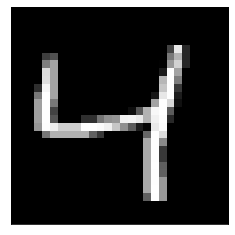

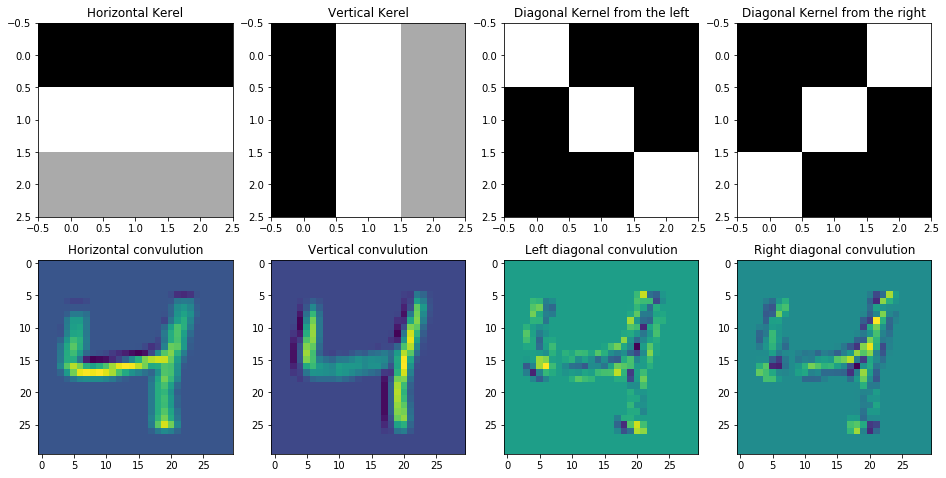

In [13]:
# The image
image = train_data[2][0].reshape((28, 28))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray")
ax.set_xticks([], []) ; ax.set_yticks([], [])

# 1. Create kernels
kernel_template = [ [-1.0, -1.0, -1.0], 
                    [-1.0,  2.0, -1.0], 
                    [-1.0, -1.0, -1.0] ]   # example: point detector

horizontal =  [ [-1.0, -1.0, -1.0],
                [ 2.0,  2.0,  2.0], 
                [ 1.0,  1.0,  1.0] ] 

vertical   =[ [-1.0,  2.0,  1.0], 
              [-1.0,  2.0,  1.0], 
              [-1.0,  2.0,  1.0]] 

diagonal_left = [[ 2.0, -1.0, -1.0], 
                 [-1.0,  2.0, -1.0], 
                 [-1.0, -1.0,  2.0] ] 

diagonal_right= [[-1.0, -1.0,  2.0], 
                 [-1.0,  2.0, -1.0], 
                 [ 2.0, -1.0, -1.0] ]
## Code here ##

# 2. Plot kernels
fig, ax = plt.subplots(2, 4, figsize=(16,8))
ax[0,0].imshow(horizontal,cmap="gray")
ax[0,0].set_title("Horizontal Kerel")

ax[0,1].imshow(vertical,cmap="gray")
ax[0,1].set_title("Vertical Kerel")

ax[0,2].imshow(diagonal_left,cmap="gray")
ax[0,2].set_title("Diagonal Kernel from the left")

ax[0,3].imshow(diagonal_right,cmap="gray")
ax[0,3].set_title("Diagonal Kernel from the right")



# 3. Convolve the image with the kernels
horizontal_image     = ss.convolve2d(image,horizontal)
vertical_image       = ss.convolve2d(image,vertical)
diagonal_left_image  = ss.convolve2d(image,diagonal_left)
diagonal_right_image = ss.convolve2d(image,diagonal_right)

# 4. Plot the activity maps
ax[1,0].imshow(horizontal_image)
ax[1,0].set_title("Horizontal convulution")
ax[1,1].imshow(vertical_image)
ax[1,1].set_title("Vertical convulution")
ax[1,2].imshow(diagonal_left_image)
ax[1,2].set_title("Left diagonal convulution")
ax[1,3].imshow(diagonal_right_image)
ax[1,3].set_title("Right diagonal convulution")
plt.show()


### Exercise 7: Setup a CNN (1 points)
As a second model, setup a CNN with:
1. One convolutional layer and one linear (i.e., fully connected) weight layer.
1. In the convolutional layer, use $8$ kernels of size $3\times3$ and stride $1$.
1. ReLU units in the hidden layer.
1. Max pooling with kernels of size $2\times2$ and stride $2$.

### Solution 7

In [14]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super (ConvolutionalNeuralNetwork,self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.relu = nn.ReLU()
        self.fc1   = nn.Linear(8*14*14,10)
    
    def forward(self,x):
        #print("Shape of x is: "+str(x.shape))
        out = self.conv(x.reshape(-1,1,28,28))
        #print("Shape of out is: "+str(out.shape))
        out = self.pool(out)
        out = self.relu(out)
        out = out.reshape(x.size(0), -1)
        out = self.fc1(out)
        return out



### Exercise 8: Train the CNN (1 point) 
Train the CNN using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the CNN in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 8

In [15]:
convNet = ConvolutionalNeuralNetwork().to(device)
optimizer = torch.optim.SGD(convNet.parameters(),lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [16]:
print(convNet)

ConvolutionalNeuralNetwork(
  (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


In [17]:
convModel,conv_train_loss,conv_valid_loss,conv_train_accuracy,conv_valid_accuracy = train_model(convNet,
                                                                                    train_loader,
                                                                                    valid_loader,
                                                                                    optimizer,
                                                                                    criterion,
                                                                                    n_epochs=20)

epoch : [1,20], train loss : 0.8275, train accuracy : 80.16%, valid loss : 0.3699, valid acc : 89.98%,
epoch : [2,20], train loss : 0.3605, train accuracy : 89.56%, valid loss : 0.3194, valid acc : 90.75%,
epoch : [3,20], train loss : 0.3274, train accuracy : 90.39%, valid loss : 0.2998, valid acc : 91.42%,
epoch : [4,20], train loss : 0.3113, train accuracy : 90.85%, valid loss : 0.2909, valid acc : 91.80%,
epoch : [5,20], train loss : 0.3008, train accuracy : 91.25%, valid loss : 0.2815, valid acc : 91.83%,
epoch : [6,20], train loss : 0.2921, train accuracy : 91.44%, valid loss : 0.2721, valid acc : 92.20%,
epoch : [7,20], train loss : 0.2852, train accuracy : 91.70%, valid loss : 0.2702, valid acc : 92.18%,
epoch : [8,20], train loss : 0.2781, train accuracy : 91.93%, valid loss : 0.2633, valid acc : 92.41%,
epoch : [9,20], train loss : 0.2725, train accuracy : 92.15%, valid loss : 0.2544, valid acc : 92.71%,
epoch : [10,20], train loss : 0.2654, train accuracy : 92.36%, valid loss

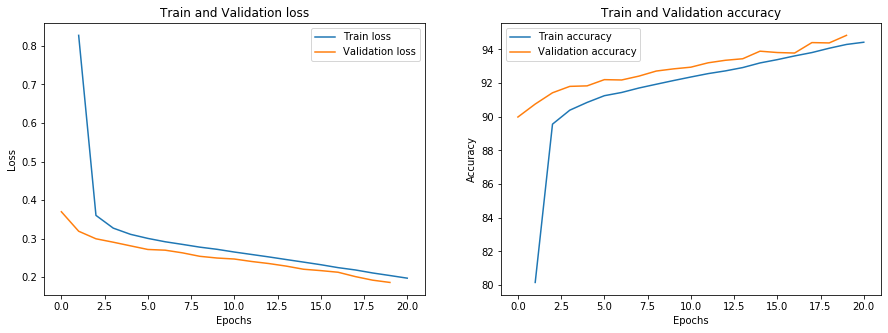

In [18]:
epoch_plot = np.arange(1,21)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(epoch_plot,conv_train_loss,conv_valid_loss)
ax1.set_title("Train and Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(["Train loss","Validation loss"])

ax2.plot(epoch_plot,conv_train_accuracy,conv_valid_accuracy)
ax2.set_title("Train and Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(["Train accuracy","Validation accuracy"])

plt.show()

### Exercise 9: Visualize the weights (0.5 points)
The model's weights in the convolutional layer that the CNN has learned can be found in `model_name.layer_name.weight.data`. Plot the kernels as images.

Showing what the first weight layer learns is easy. But this task becomes more difficult in higher layers, and is a current area of research. Here is highly recommended reading on what convolutional neural networks learn: 

[Feature visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

[The building blocks of interpretability](https://distill.pub/2018/building-blocks/)

### Solution 9

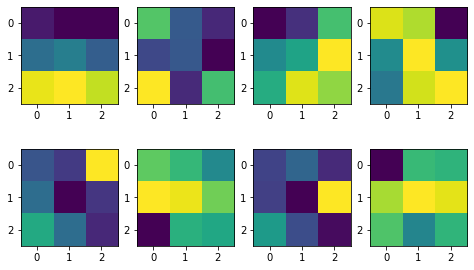

In [19]:
wc = convModel.conv.weight.data.numpy().reshape(8,3,3)

plt.figure(figsize=([8,10]))
for i in range(len(wc)):
    plt.subplot(4,4,i+1)
    fig = plt.imshow(wc[i].reshape([3,3]))

plt.show()

### Exercise 10: Interpretation (2 points)
1. Which of the two models performed better for classifying MNIST digits in this example? Compare speed of training and test set accuracy. 
1. The main difference of the models is the type of the first layer. Why would a convolutional layer lead to the better succes here? 
1. Explain one argument why the convolution operation is biologically plausible and one argument why it is biologically implausible. 

### Solution 10
1. Comparison of the 2 algorithms 
    * Accuracy: When it comes to accuracy the Convolutional Neural Network outperfomed the MLP by two to three percent depending on the run. 
    * Training Speed: I used the time library to record the time elapsed and print it at the end during training. The MLP converged much faster, it took an order of 100 seconds less. 
1. Answer here.
1. Answer here.